# Recommender Systems Lab

This notebook provides an introduction to building movie recommender systems using data from the famous 2006 **Netflix Prize** Competition. Netflix offered a prize of one million dollars for the first algorithm that could beat its own recommendation system by 10%. The prize was finally won in 2009, by a team of researchers called “Bellkor’s
Pragmatic Chaos,” after over three years of competition. More details [here](https://en.wikipedia.org/wiki/Netflix_Prize). Kaggle have made the data available [here](https://www.kaggle.com/netflix-inc/netflix-prize-data).

### Overall Goal of Lab

We'll be building and evaluation automated recommendation engines capable of telling us: What are the top movies a user would most like to watch (which they haven't done already)?

We'll be doing this using two different methods, **Content-Based** Filtering and **Collaborative** Filtering.

### Why are Recommender Systems important/interesting?
*   Online companies (e.g. Amazon, Netflix etc) have too many products for customers to be able to consider. Automated recommendation systems are needed to filter the right subset of products to each customer (i.e. the ones they're most likely to buy).
*   Recommender systems are a rare example of an **Unsupervised Machine Learning technique** being hugely valuable for business applications. Typically it's the supervised algorithms which tend to get most of the limelight. Recommender systems are unsupervised as they make recommendations based on similarity in the data, rather than predicting a target variable.

### The Power of Recommender Systems: Into Thin Air and Touching the Void

Touching the Void is a mountain-climbing book that was not a big seller in its day, but many years after it was published, another book on the same topic, called Into Thin Air was published. Amazon’s recommendation system noticed a few people who bought both books, and started recommending Touching the Void to people who bought, or were considering, Into Thin Air. Touching the Void eventually became very popular in its own right, in fact, more so than Into Thin Air. More details [here](https://www.wired.com/2004/10/tail/).

### Lab Tasks

This lab will be made up of the following high level steps:
1. Load in data
2. Basic EDA
3. Build Content-Based filtering system
4. Build and Evaluate Collaborative filtering systems

### First a bit of Theory

The central data structure in recommender systems is the **Utility Matrix** which shows the known ratings/preferences each user has assigned to each product.

<img src="https://www.researchgate.net/profile/Tommaso_Di_Noia/publication/300646445/figure/fig2/AS:360201661239310@1462890176315/Example-of-user-item-ratings-matrix-in-a-movie-recommendation-scenario.png">

The goal of any Recommender System is to

1. fill in the blanks in this matrix. E.g. How much would Alice like the movies Seven and Heat based on her known preferences and/or those of John and Tom?
2. recommend the movies with the highest estimated ratings. E.g. Let's recommend the movie Heat to Alice, as she is expected to like it more than Seven.

There are two main types of algorithm for doing this, both based on the concept of **similarity**. You can either recommend movies based on:
* the most similar movies to the user's known/historic preferences (content-based)
* the most highly rated movies by other users with similar preferences (collaborative)

<img src="http://datameetsmedia.com/wp-content/uploads/2018/05/2ebah6c-1.png">

Obvious question to ask now: how will we measure similarity? We will be using **cosine similarity**. This measures the similarity between two vectors (e.g. movie attributes/user ratings) based on the angle between them.

<img src='http://i.imgur.com/BmW31s9.png'>

## 1 Load in Data

In [1]:
#import libraries
import pandas as pd

In [2]:
#load in user-item-ratings data
ratings = pd.read_csv('ratings.csv')
#show top 5 rows
ratings.head()

,user_id,rating,rating_date,movie_id
0,2625420,2.0,2004-05-13,28.0
1,908205,4.0,2005-03-29,28.0
2,1984086,5.0,2004-09-18,28.0
3,303948,4.0,2004-08-29,28.0
4,1673185,3.0,2003-10-06,28.0


In [3]:
#load in user lookup table
users = pd.read_csv('users.csv')
#show top 5 rows
users.head()

,user_id,name
0,305344,Pat Carpenter
1,387418,Ignacio Norman
2,2439493,Timothy Martin
3,1664010,Tracey Mann
4,2118461,Ollie Wilkins


NB: the user id's are real and correspond to actual Netflix users. However the assigned names were randomly generated and do not correspond to the actual names of these users. They have just been added in to make the analysis more interesting (instead of just using the id's which are pretty dry).

In [4]:
#load in movies lookup table
movies = pd.read_csv('movies.csv')
movies.head()

,netflix_id,imdb_id,year,title
0,1905.0,tt0325980,2003,Pirates of the Caribbean: The Curse of the Bla...
1,2152.0,tt0207201,2000,What Women Want
2,3860.0,tt0315327,2003,Bruce Almighty
3,4432.0,tt0317740,2003,The Italian Job
4,571.0,tt0169547,1999,American Beauty


## 2 Basic EDA
Let's do some basic visualisations and calculations to get a better understanding of the data we're working with, and the kind of recommendations we may expect to see.

In [5]:
#import matplotlib for data vis
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#let's see how many users we're working with
users.shape

(155, 2)

In [7]:
#how many movies?
movies.shape

(300, 4)

In [8]:
#how many ratings?
ratings.shape

(35594, 4)

In [9]:
# show utility matrix of user-item preferences
u_matrix = pd.pivot_table(ratings,values='rating',index='user_id',columns='movie_id')

u_matrix.head()

movie_id,28.0,30.0,58.0,83.0,108.0,118.0,143.0,148.0,175.0,187.0,...,4364.0,4369.0,4384.0,4389.0,4402.0,4420.0,4432.0,4472.0,4479.0,4488.0
user_id,,,,,,,,,,,,,,,,,,,,,
3321,4.0,5.0,4.0,3.0,NaN,4.0,3.0,2.0,NaN,NaN,...,NaN,4.0,4.0,NaN,4.0,2.0,NaN,2.0,4.0,3.0
16272,2.0,4.0,4.0,3.0,2.0,4.0,4.0,3.0,NaN,1.0,...,3.0,2.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,4.0
49890,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,NaN,...,5.0,5.0,5.0,2.0,5.0,4.0,4.0,5.0,5.0,4.0
57633,NaN,2.0,2.0,4.0,3.0,1.0,3.0,2.0,4.0,1.0,...,5.0,2.0,4.0,NaN,2.0,1.0,5.0,3.0,5.0,4.0
71594,3.0,NaN,4.0,3.0,NaN,4.0,5.0,NaN,3.0,2.0,...,NaN,2.0,2.0,NaN,4.0,NaN,3.0,NaN,3.0,NaN


There are a few blanks showing up, representing films which haven't yet been rated (and presumably watched) by users. What % of ratings are missing?

In [10]:
#how sparse are the ratings (i.e. % of missing ratings)
num_unknown_ratings = u_matrix.isnull().sum().sum()
max_possible_ratings = u_matrix.shape[0]*u_matrix.shape[1]
print('% ratings missing:',num_unknown_ratings/max_possible_ratings)

% ratings missing: 0.23453763440860215


Approx. 25% of ratings are missing. I.e. on average each user has not yet rated around 25% of the films in the data. 

What's the overall average user rating for each film?

In [11]:
#average rating overall
print('average overall rating:',ratings['rating'].mean())

average overall rating: 3.3019610046637076


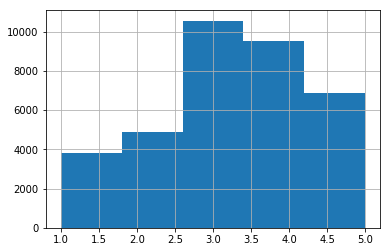

In [12]:
#spread of ratings
ratings['rating'].hist(bins=5)

Let's get some samples of movies we may expect to see appear in recommendations (e.g. most highly rated, most frequently rated/most popular)

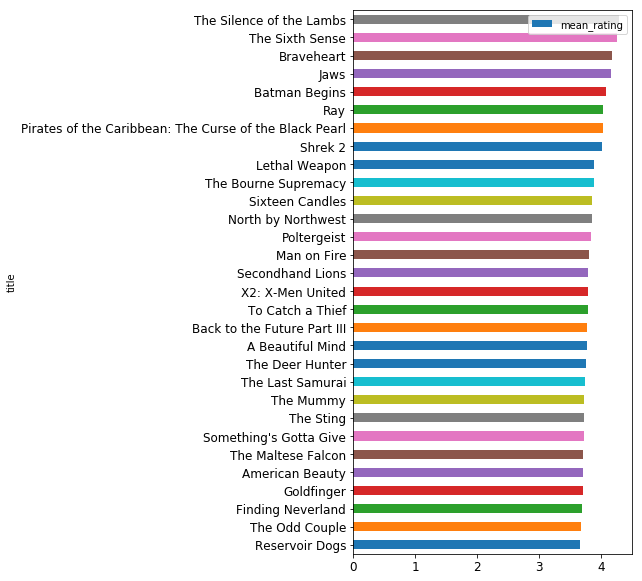

In [13]:
#get average rating per movie
movie_average_rating = ratings.groupby('movie_id',as_index=False).agg({'rating':'mean'})\
                        .rename(columns={'rating':'mean_rating'})

#merge in movie titles
movie_average_rating = pd.concat([movie_average_rating.set_index('movie_id'),movies.set_index('netflix_id')],\
                                join='inner',axis=1,sort=True).reset_index()

#show top films with highest average rating
movie_average_rating.sort_values(by='mean_rating',ascending=True)[-30:].plot.barh(x='title',y='mean_rating',\
                                                                                figsize=(5,10),fontsize=12)

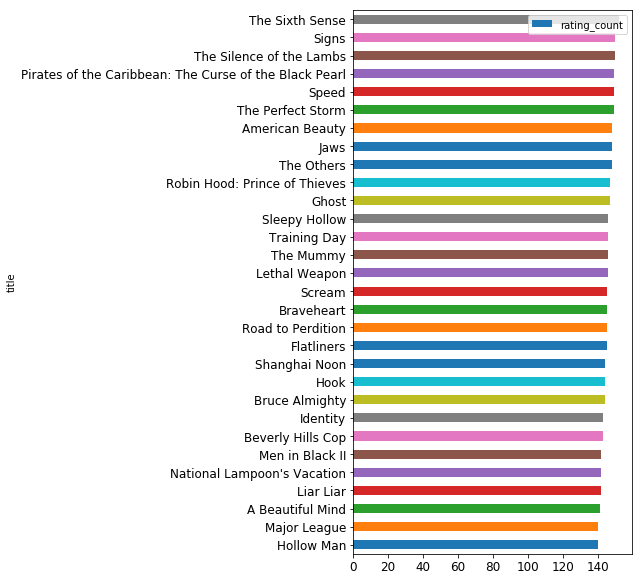

In [14]:
#get movie rating counts
movie_ratings_count = ratings.groupby('movie_id',as_index=False).agg({'rating':'count'})\
                        .rename(columns={'rating':'rating_count'})

#merge in movie titles
movie_ratings_count = pd.concat([movie_ratings_count.set_index('movie_id'),movies.set_index('netflix_id')],\
                                join='inner',axis=1,sort=True).reset_index()

#show top most frequently rated (i.e. popular/most frequently watched) movies 
movie_ratings_count.sort_values(by='rating_count',ascending=True)[-30:].plot.barh(x='title',y='rating_count',\
                                                                                figsize=(5,10),fontsize=12)

Let's now show a sample of the most obscure films (i.e. least rated). These may represent the 'hidden gems' in the data; movies which users would like even though they're not very popular/well known.

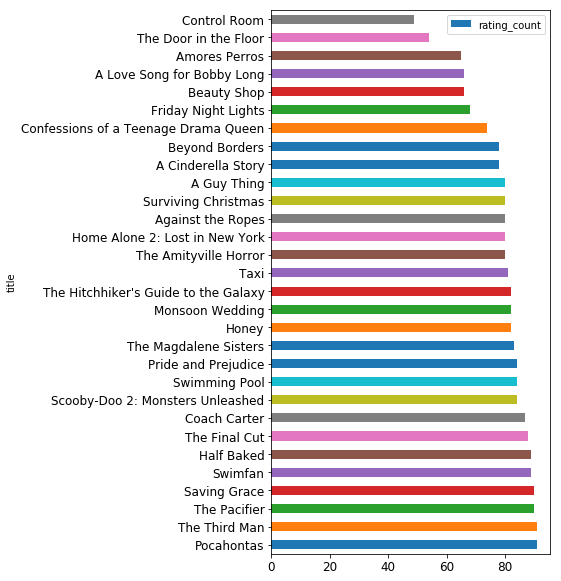

In [15]:
#most obscure films
movie_ratings_count = ratings.groupby('movie_id',as_index=False).agg({'rating':'count'})\
                        .rename(columns={'rating':'rating_count'})

movie_ratings_count = pd.concat([movie_ratings_count.set_index('movie_id'),movies.set_index('netflix_id')],\
                                join='inner',axis=1,sort=True).reset_index()


movie_ratings_count.sort_values(by='rating_count',ascending=False)[-30:].plot.barh(x='title',y='rating_count',\
                                                                                figsize=(5,10),fontsize=12)

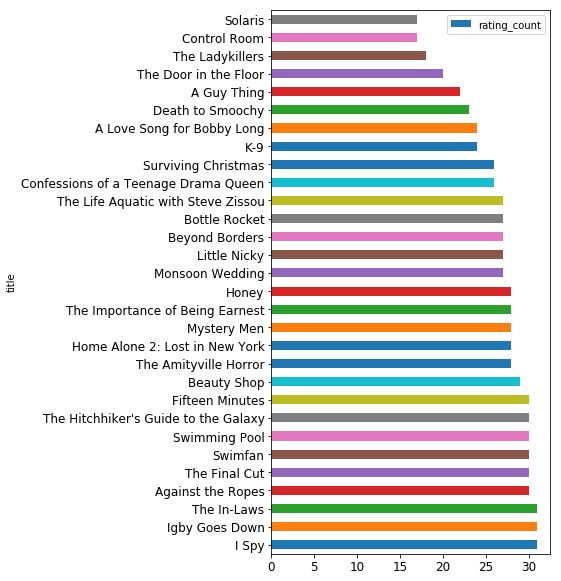

In [16]:
#Most obscure films with highest ratings (hidden gems maybe?)
is_highly_rated = (ratings['rating']>=4)
movie_ratings_count = ratings[is_highly_rated].groupby('movie_id',as_index=False).agg({'rating':'count'})\
                        .rename(columns={'rating':'rating_count'})

movie_ratings_count = pd.concat([movie_ratings_count.set_index('movie_id'),movies.set_index('netflix_id')],\
                                join='inner',axis=1,sort=True).reset_index()

movie_ratings_count.sort_values(by='rating_count',ascending=False)[-30:].plot.barh(x='title',y='rating_count',\
                                                                                figsize=(5,10),fontsize=12)

## 3 Build Content-Based Filtering System
Content-based filtering consists of these steps:
1. Create movie profiles (profile capturing movie attributes)
2. Create user profile (aggregated movie profile capturing user preferences across each movie attribute based on their known ratings)
3. Find most similar movies to user preferences (by measuring similarity of movie profiles to user profile)

### 3.1 Create movie profiles
Each movie's profile is a data row with each column describing an attribute about that film. We use these movie profiles to calculate how similar one movie is to another (by comparing them across each attribute using cosine similarity). The attributes we'll be including in each movie profile are:
* movie release year
* movie genre
* director
* actors
* top descriptors in movie summary text (i.e. synopsis)

We don't have most of the information needed to build these profiles. To get this info, we will scrape it from the imdb website.

In general, here is a list of the key steps we'll go through to build the profiles:
* scrape movie attribute info from imdb website
* cleanse/transform scraped data into useable format.
* extract top descriptors from movie summary text, using TF-IDF
* transform categorical attributes into binary flags in order to calculate similarity, e.g. create a 'Tom Cruise' flag which is 1 when Tom Cruise is in a film, 0 otherwise.
* rescale the movie release year attribute to avoid it overpowering other attributes when calculating similarity

**Scraping info from imdb website**

In [17]:
#import request library to make calls to imdb website and get html code 
import requests
#import beautiful soup to parse html code so we can extract out the information we want
from bs4 import BeautifulSoup
#import time library to time execution of code
import time

In [18]:
#define function to get html from each movie's imdb page, and parse it using beautifulsoup
def get_imdb_page(imdb_id):
    #get url for movie's imdb page (same base url with movie's imdb_id on the end)
    url = 'https://www.imdb.com/title/'+imdb_id
    #send request for that url to get web page html 
    response = requests.get(url) 
    #parse web page html using beautiful - will then let you extract out key bits of html (i.e. scrape web page)
    response_parsed = BeautifulSoup(response.text,'html.parser')  
    return response_parsed

Let's get html for the Iron Man imdb [page](https://www.imdb.com/title/tt0371746/)

In [19]:
#get parsed html of iron man imdb web page
imdb_page = get_imdb_page('tt0371746')
#show html - this is what we'll be scraping to get key info needed to build movie profile
print(imdb_page.prettify())

<!DOCTYPE html>
<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="app-id=342792525, app-argument=imdb:///title/tt0371746?src=mdot" name="apple-itunes-app"/>
  <script type="text/javascript">
   var IMDbTimer={starttime: new Date().getTime(),pt:'java'};
  </script>
  <script>
   if (typeof uet == 'function') {
      uet("bb", "LoadTitle", {wb: 1});
    }
  </script>
  <script>
   (function(t){ (t.events = t.events || {})["csm_head_pre_title"] = new Date().getTime(); })(IMDbTimer);
  </script>
  <title>
   Iron Man (2008) - IMDb
  </title>
  <script>
   (function(t){ (t.events = t.events || {})["csm_head_post_title"] = new Date().getTime(); })(IMDbTimer);
  </script>
  <script>
   if (typeof uet == 'function') {
      uet("be", "LoadTitle", {wb: 1});
    }
  </script>
  <script>
   if (typeof uex == 'function') {
      uex("ld", "LoadTitle", {wb: 1});

You can also view the html directly on google chrome using developer tools. This is actually the best way to find out the specific html tags/classes of the data items you're interested in. You can then reference these tags (using beautiful soup) to scrape out the data

In [20]:
#let's get the movie's summary text from the parsed html
imdb_page.find('div', class_ = 'summary_text').text.strip('\n').strip()

'After being held captive in an Afghan cave, billionaire engineer Tony Stark creates a unique weaponized suit of armor to fight evil.'

In [21]:
#let's get the director name and actor names
#loop through all items with 'div' tag and 'credit_summary_item' class (contain director/actor items)
for div in imdb_page.findAll('div', attrs={'class':'credit_summary_item'}):
    #check for director data item
    if div.find('h4').contents[0]=='Director:':
      #print director item
      print(div.find('a').contents[0])
    #check for actor items
    elif div.find('h4').contents[0]=='Stars:':
      #print actor items
      print([actor.contents[0] for actor in div.findAll('a')[0:3]])

Jon Favreau
['Robert Downey Jr.', 'Gwyneth Paltrow', 'Terrence Howard']


In [22]:
#let's get the genres
#loop through all genre items
for div in imdb_page.findAll('div', attrs={'class':'subtext'}):
    #print genres
    print([genre.contents[0] for genre in div.findAll('a')[0:3]])

['Action', 'Adventure', 'Sci-Fi']


Let's define a function which scrapes all the key bits of information we want, and stores it as a disctionary

In [23]:
#let's define function to extract imdb info and return as dict
def get_imdb_info(imdb_id):
  #get html of imdb page
  imdb_page = get_imdb_page(imdb_id)
  #create empty dict to store info scraped from imdb page
  imdb_info = {}
  #get summary text
  imdb_info['summary_text'] = \
  imdb_page.find('div', class_ = 'summary_text').text.strip('\n').strip()
  #get main director and top 3 actors
  for div in imdb_page.findAll('div', attrs={'class':'credit_summary_item'}):
    if div.find('h4').contents[0]=='Director:':
      imdb_info['director'] = div.find('a').contents[0]
    elif div.find('h4').contents[0]=='Stars:':
        imdb_info['actors'] = \
        [actor.contents[0] for actor in div.findAll('a')[0:3]]
  #get genres
  for div in imdb_page.findAll('div', attrs={'class':'subtext'}):
    imdb_info['genres'] = \
        [genre.contents[0] for genre in div.findAll('a')[0:3]]
  #return imdb info
  return imdb_info

In [24]:
#run function on first 5 movies to get their imdb info
time_start = time.time()
imdb_info = list(movies.head()['imdb_id'].apply(get_imdb_info))
print('time elapsed:',(time.time() - time_start))
imdb_info

time elapsed: 5.509791135787964


[{'summary_text': 'Blacksmith Will Turner teams up with eccentric pirate "Captain" Jack Sparrow to save his love, the governor\'s daughter, from Jack\'s former pirate allies, who are now undead.',
  'director': 'Gore Verbinski',
  'actors': ['Johnny Depp', 'Geoffrey Rush', 'Orlando Bloom'],
  'genres': ['Action', 'Adventure', 'Fantasy']},
 {'summary_text': 'After an accident, a chauvinistic executive gains the ability to hear what women are really thinking.',
  'director': 'Nancy Meyers',
  'actors': ['Mel Gibson', 'Helen Hunt', 'Marisa Tomei'],
  'genres': ['Comedy', 'Fantasy', 'Romance']},
 {'summary_text': 'A guy who complains about God too often is given almighty powers to teach him how difficult it is to run the world.',
  'director': 'Tom Shadyac',
  'actors': ['Jim Carrey', 'Jennifer Aniston', 'Morgan Freeman'],
  'genres': ['Comedy', 'Drama', 'Fantasy']},
 {'summary_text': 'After being betrayed and left for dead in Italy, Charlie Croker and his team plan an elaborate gold heist

Scraping information for 300 movies takes approx. 5 minutes! Instead, let's load in a text file containing pre-scraped imdb info.

In [25]:
import json
#reload scraped imdb info in text file as a list
file = open('imdb_info.txt')
imdb_info = []
for line in file:
    item = json.loads(line)
    imdb_info.append(item)

# Close connection to file
file.close()

len(imdb_info)

300

In [26]:
#let's see imdb info for first 5 films
imdb_info[:5]

[{'summary_text': 'Blacksmith Will Turner teams up with eccentric pirate "Captain" Jack Sparrow to save his love, the governor\'s daughter, from Jack\'s former pirate allies, who are now undead.',
  'director': 'Gore Verbinski',
  'actors': ['Johnny Depp', 'Geoffrey Rush', 'Orlando Bloom'],
  'genres': ['Action', 'Adventure', 'Fantasy']},
 {'summary_text': 'After an accident, a chauvinistic executive gains the ability to hear what women are really thinking.',
  'director': 'Nancy Meyers',
  'actors': ['Mel Gibson', 'Helen Hunt', 'Marisa Tomei'],
  'genres': ['Comedy', 'Fantasy', 'Romance']},
 {'summary_text': 'A guy who complains about God too often is given almighty powers to teach him how difficult it is to run the world.',
  'director': 'Tom Shadyac',
  'actors': ['Jim Carrey', 'Jennifer Aniston', 'Morgan Freeman'],
  'genres': ['Comedy', 'Drama', 'Fantasy']},
 {'summary_text': 'After being betrayed and left for dead in Italy, Charlie Croker and his team plan an elaborate gold heist

**Cleanse/transform data in order to create item profiles**

In [27]:
#turn scraped imdb info into dataframe
item_profiles_raw = pd.DataFrame(imdb_info)
#check number of rows
print(item_profiles_raw.shape)
#check top 5 rows
item_profiles_raw.head()

(300, 4)


,actors,director,genres,summary_text
0,"[Johnny Depp, Geoffrey Rush, Orlando Bloom]",Gore Verbinski,"[Action, Adventure, Fantasy]",Blacksmith Will Turner teams up with eccentric...
1,"[Mel Gibson, Helen Hunt, Marisa Tomei]",Nancy Meyers,"[Comedy, Fantasy, Romance]","After an accident, a chauvinistic executive ga..."
2,"[Jim Carrey, Jennifer Aniston, Morgan Freeman]",Tom Shadyac,"[Comedy, Drama, Fantasy]",A guy who complains about God too often is giv...
3,"[Donald Sutherland, Mark Wahlberg, Edward Norton]",F. Gary Gray,"[Action, Crime, Thriller]",After being betrayed and left for dead in Ital...
4,"[Kevin Spacey, Annette Bening, Thora Birch]",Sam Mendes,"[Drama, 1 October 1999 (USA)\n]",A sexually frustrated suburban father has a mi...


In [28]:
#merge in info from movies lookup table
item_profiles_raw = pd.concat([movies,item_profiles_raw],join='inner',axis=1)
print(item_profiles_raw.shape)
item_profiles_raw.head()

(300, 8)


,netflix_id,imdb_id,year,title,actors,director,genres,summary_text
0,1905.0,tt0325980,2003,Pirates of the Caribbean: The Curse of the Bla...,"[Johnny Depp, Geoffrey Rush, Orlando Bloom]",Gore Verbinski,"[Action, Adventure, Fantasy]",Blacksmith Will Turner teams up with eccentric...
1,2152.0,tt0207201,2000,What Women Want,"[Mel Gibson, Helen Hunt, Marisa Tomei]",Nancy Meyers,"[Comedy, Fantasy, Romance]","After an accident, a chauvinistic executive ga..."
2,3860.0,tt0315327,2003,Bruce Almighty,"[Jim Carrey, Jennifer Aniston, Morgan Freeman]",Tom Shadyac,"[Comedy, Drama, Fantasy]",A guy who complains about God too often is giv...
3,4432.0,tt0317740,2003,The Italian Job,"[Donald Sutherland, Mark Wahlberg, Edward Norton]",F. Gary Gray,"[Action, Crime, Thriller]",After being betrayed and left for dead in Ital...
4,571.0,tt0169547,1999,American Beauty,"[Kevin Spacey, Annette Bening, Thora Birch]",Sam Mendes,"[Drama, 1 October 1999 (USA)\n]",A sexually frustrated suburban father has a mi...


In [29]:
import numpy as np
#define function to add nans into actors and genre lists so that they all consist of 3 elements
#this will simplify splitting up actors & genres into separate columns later on
def add_nans(actors):
    if len(actors)==3:
        return actors
    elif len(actors)==2:
        actors.append(np.nan)
        return actors
    elif len(actors)==1:
        actors.append([np.nan,np.nan])
        return actors

In [30]:
#apply add_nans to actors and genres columns
item_profiles_raw['actors'] = item_profiles_raw['actors'].apply(add_nans)
item_profiles_raw['genres'] = item_profiles_raw['genres'].apply(add_nans)
item_profiles_raw.head()

,netflix_id,imdb_id,year,title,actors,director,genres,summary_text
0,1905.0,tt0325980,2003,Pirates of the Caribbean: The Curse of the Bla...,"[Johnny Depp, Geoffrey Rush, Orlando Bloom]",Gore Verbinski,"[Action, Adventure, Fantasy]",Blacksmith Will Turner teams up with eccentric...
1,2152.0,tt0207201,2000,What Women Want,"[Mel Gibson, Helen Hunt, Marisa Tomei]",Nancy Meyers,"[Comedy, Fantasy, Romance]","After an accident, a chauvinistic executive ga..."
2,3860.0,tt0315327,2003,Bruce Almighty,"[Jim Carrey, Jennifer Aniston, Morgan Freeman]",Tom Shadyac,"[Comedy, Drama, Fantasy]",A guy who complains about God too often is giv...
3,4432.0,tt0317740,2003,The Italian Job,"[Donald Sutherland, Mark Wahlberg, Edward Norton]",F. Gary Gray,"[Action, Crime, Thriller]",After being betrayed and left for dead in Ital...
4,571.0,tt0169547,1999,American Beauty,"[Kevin Spacey, Annette Bening, Thora Birch]",Sam Mendes,"[Drama, 1 October 1999 (USA)\n, nan]",A sexually frustrated suburban father has a mi...


In [31]:
#define function to replace dates in genres column with nan
def remove_dates(genres):
    #genres = list(genres)
    new_genres = []
    for genre in genres:
        genre = str(genre)
        if any(char.isdigit() for char in genre):
            new_genres.append(np.nan)
        else:
            new_genres.append(genre)
    return new_genres

In [32]:
#apply remove dates function on genres column
item_profiles_raw['genres'] = item_profiles_raw['genres'].apply(remove_dates)
item_profiles_raw.head()

,netflix_id,imdb_id,year,title,actors,director,genres,summary_text
0,1905.0,tt0325980,2003,Pirates of the Caribbean: The Curse of the Bla...,"[Johnny Depp, Geoffrey Rush, Orlando Bloom]",Gore Verbinski,"[Action, Adventure, Fantasy]",Blacksmith Will Turner teams up with eccentric...
1,2152.0,tt0207201,2000,What Women Want,"[Mel Gibson, Helen Hunt, Marisa Tomei]",Nancy Meyers,"[Comedy, Fantasy, Romance]","After an accident, a chauvinistic executive ga..."
2,3860.0,tt0315327,2003,Bruce Almighty,"[Jim Carrey, Jennifer Aniston, Morgan Freeman]",Tom Shadyac,"[Comedy, Drama, Fantasy]",A guy who complains about God too often is giv...
3,4432.0,tt0317740,2003,The Italian Job,"[Donald Sutherland, Mark Wahlberg, Edward Norton]",F. Gary Gray,"[Action, Crime, Thriller]",After being betrayed and left for dead in Ital...
4,571.0,tt0169547,1999,American Beauty,"[Kevin Spacey, Annette Bening, Thora Birch]",Sam Mendes,"[Drama, nan, nan]",A sexually frustrated suburban father has a mi...


In [33]:
#split actors into separate columns
actor_columns = ['actor_1','actor_2','actor_3']
for i in range(0,3):
    item_profiles_raw[actor_columns[i]] = item_profiles_raw['actors'].apply(lambda x: x[i])

#remove original actors column
item_profiles_raw.drop(['actors'],axis=1,inplace=True)
    
item_profiles_raw.head()

,netflix_id,imdb_id,year,title,director,genres,summary_text,actor_1,actor_2,actor_3
0,1905.0,tt0325980,2003,Pirates of the Caribbean: The Curse of the Bla...,Gore Verbinski,"[Action, Adventure, Fantasy]",Blacksmith Will Turner teams up with eccentric...,Johnny Depp,Geoffrey Rush,Orlando Bloom
1,2152.0,tt0207201,2000,What Women Want,Nancy Meyers,"[Comedy, Fantasy, Romance]","After an accident, a chauvinistic executive ga...",Mel Gibson,Helen Hunt,Marisa Tomei
2,3860.0,tt0315327,2003,Bruce Almighty,Tom Shadyac,"[Comedy, Drama, Fantasy]",A guy who complains about God too often is giv...,Jim Carrey,Jennifer Aniston,Morgan Freeman
3,4432.0,tt0317740,2003,The Italian Job,F. Gary Gray,"[Action, Crime, Thriller]",After being betrayed and left for dead in Ital...,Donald Sutherland,Mark Wahlberg,Edward Norton
4,571.0,tt0169547,1999,American Beauty,Sam Mendes,"[Drama, nan, nan]",A sexually frustrated suburban father has a mi...,Kevin Spacey,Annette Bening,Thora Birch


In [34]:
#split genres into separate columns
genre_columns = ['genre_1','genre_2','genre_3']
for i in range(0,3):
    item_profiles_raw[genre_columns[i]] = item_profiles_raw['genres'].apply(lambda x: x[i])

#remove original genres column
item_profiles_raw.drop(['genres'],axis=1,inplace=True)
    
item_profiles_raw.head()

,netflix_id,imdb_id,year,title,director,summary_text,actor_1,actor_2,actor_3,genre_1,genre_2,genre_3
0,1905.0,tt0325980,2003,Pirates of the Caribbean: The Curse of the Bla...,Gore Verbinski,Blacksmith Will Turner teams up with eccentric...,Johnny Depp,Geoffrey Rush,Orlando Bloom,Action,Adventure,Fantasy
1,2152.0,tt0207201,2000,What Women Want,Nancy Meyers,"After an accident, a chauvinistic executive ga...",Mel Gibson,Helen Hunt,Marisa Tomei,Comedy,Fantasy,Romance
2,3860.0,tt0315327,2003,Bruce Almighty,Tom Shadyac,A guy who complains about God too often is giv...,Jim Carrey,Jennifer Aniston,Morgan Freeman,Comedy,Drama,Fantasy
3,4432.0,tt0317740,2003,The Italian Job,F. Gary Gray,After being betrayed and left for dead in Ital...,Donald Sutherland,Mark Wahlberg,Edward Norton,Action,Crime,Thriller
4,571.0,tt0169547,1999,American Beauty,Sam Mendes,A sexually frustrated suburban father has a mi...,Kevin Spacey,Annette Bening,Thora Birch,Drama,NaN,nan


**Extracting out top descriptors from movie summary text**

The code below looks through the words in each movie's summary text field, calculates the TF-IDF score for each word, and returns the 3 words with the highest scores. These correspond to the top 3 words that best characterise the summary text (i.e. top descriptors). 

This is because if a word has high TF-IDF score within a specific summary, this means it appears frequently in that summary and not so much in any other summary (i.e. the word is characteristic of that summary). More info on TF-IDF [here](http://www.tfidf.com/)

In [35]:
#CLEANSE SUMMARY TEXT
import re
#function to cleanse text in summary field
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("<!--?.*?-->","",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text
 
#apply pre-process function on summary text to create cleansed version (called summary text new)
item_profiles_raw['summary_text_new'] = item_profiles_raw['summary_text'].apply(lambda x:pre_process(x))

#####################################################################################################################

#CREATE VECTORS SHOWING NUMBER OF OCCURRENCES OF WORDS IN EACH SUMMARY TEXT ITEM

from sklearn.feature_extraction.text import CountVectorizer

#get the text column 
docs=item_profiles_raw['summary_text_new'].tolist()
 
cv=CountVectorizer(stop_words='english')
word_count_vector=cv.fit_transform(docs)


#####################################################################################################################

#TRANSFORM WORD COUNT VECTORS INTO TIF-IDF VECTORS, I.E. SHOWING TF-IDF OF WORDS IN EACH SUMMARY TEXT  ITEM

from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

#####################################################################################################################

#DEFINE SET OF FUNCTIONS TO EXTRACT OUT TOP 3 WORDS WITH THE HIGHEST TF-IDF SCORES (FOR EACH SUMMARY TEXT)

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

def get_top_words(doc,num_words=3):
    # get feature names (i.e. words)
    feature_names=cv.get_feature_names()
 
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
 
    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())
 
    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,num_words)

    return list(keywords.keys())

In [36]:
#apply function to extract out top 3 words (descriptors) from summary text
item_profiles_raw['top_descriptors'] = item_profiles_raw['summary_text_new'].\
                                        apply(lambda x: get_top_words(x,num_words=3))
#make sure there are 3 top descriptor items (even if this means adding in blanks)
#as before, this facilitates splitting out descriptors into separate columns
item_profiles_raw['top_descriptors'] = item_profiles_raw['top_descriptors'].apply(add_nans)

item_profiles_raw.head()

,netflix_id,imdb_id,year,title,director,summary_text,actor_1,actor_2,actor_3,genre_1,genre_2,genre_3,summary_text_new,top_descriptors
0,1905.0,tt0325980,2003,Pirates of the Caribbean: The Curse of the Bla...,Gore Verbinski,Blacksmith Will Turner teams up with eccentric...,Johnny Depp,Geoffrey Rush,Orlando Bloom,Action,Adventure,Fantasy,blacksmith will turner teams up with eccentric...,"[pirate, jack, undead]"
1,2152.0,tt0207201,2000,What Women Want,Nancy Meyers,"After an accident, a chauvinistic executive ga...",Mel Gibson,Helen Hunt,Marisa Tomei,Comedy,Fantasy,Romance,after an accident a chauvinistic executive gai...,"[thinking, really, hear]"
2,3860.0,tt0315327,2003,Bruce Almighty,Tom Shadyac,A guy who complains about God too often is giv...,Jim Carrey,Jennifer Aniston,Morgan Freeman,Comedy,Drama,Fantasy,a guy who complains about god too often is giv...,"[powers, guy, complains]"
3,4432.0,tt0317740,2003,The Italian Job,F. Gary Gray,After being betrayed and left for dead in Ital...,Donald Sutherland,Mark Wahlberg,Edward Norton,Action,Crime,Thriller,after being betrayed and left for dead in ital...,"[elaborate, croker, charlie]"
4,571.0,tt0169547,1999,American Beauty,Sam Mendes,A sexually frustrated suburban father has a mi...,Kevin Spacey,Annette Bening,Thora Birch,Drama,NaN,nan,a sexually frustrated suburban father has a mi...,"[sexually, mid, infatuated]"


In [37]:
#split descriptors into separate columns
descriptor_columns = ['descriptor_1','descriptor_2','descriptor_3']
for i in range(0,3):
    item_profiles_raw[descriptor_columns[i]] = item_profiles_raw['top_descriptors'].apply(lambda x: x[i])

#remove original descriptors column
item_profiles_raw.drop(['summary_text_new','top_descriptors'],axis=1,inplace=True)
    
item_profiles_raw.head()

,netflix_id,imdb_id,year,title,director,summary_text,actor_1,actor_2,actor_3,genre_1,genre_2,genre_3,descriptor_1,descriptor_2,descriptor_3
0,1905.0,tt0325980,2003,Pirates of the Caribbean: The Curse of the Bla...,Gore Verbinski,Blacksmith Will Turner teams up with eccentric...,Johnny Depp,Geoffrey Rush,Orlando Bloom,Action,Adventure,Fantasy,pirate,jack,undead
1,2152.0,tt0207201,2000,What Women Want,Nancy Meyers,"After an accident, a chauvinistic executive ga...",Mel Gibson,Helen Hunt,Marisa Tomei,Comedy,Fantasy,Romance,thinking,really,hear
2,3860.0,tt0315327,2003,Bruce Almighty,Tom Shadyac,A guy who complains about God too often is giv...,Jim Carrey,Jennifer Aniston,Morgan Freeman,Comedy,Drama,Fantasy,powers,guy,complains
3,4432.0,tt0317740,2003,The Italian Job,F. Gary Gray,After being betrayed and left for dead in Ital...,Donald Sutherland,Mark Wahlberg,Edward Norton,Action,Crime,Thriller,elaborate,croker,charlie
4,571.0,tt0169547,1999,American Beauty,Sam Mendes,A sexually frustrated suburban father has a mi...,Kevin Spacey,Annette Bening,Thora Birch,Drama,NaN,nan,sexually,mid,infatuated


**Transform categorical attributes into separate binary attributes**

The categorical text attributes (e.g. director, actor_1, genre_1, etc) need to be transformed into separate numeric binary attributes [0,1] for each possible text value. 

For instance, if Tom Cruise shows up as one of the actors in the actor fields, he needs his own Tom Cruise binary numeric attribute/flag, indicating whether or not Tom Cruise is an actor in each of the films.

This then makes it possible to calculate similarity between films based on whether Tom Cruise is/isn't an actor in each film (i.e. Tom Cruis flag is 1 or 0), as *the similarity score calculation relies on attributes being numeric!*

In [38]:
#turn all categorical text values (across all attributes) into numeric binary flags
one_hot = pd.get_dummies(item_profiles_raw.drop(['summary_text','netflix_id','imdb_id','year','title'],axis=1),\
                                prefix=[None,None,None,None,None,None,None,None,None,None])
one_hot = one_hot.groupby(one_hot.columns, axis=1).sum()

#show top 5 binary attributes created
print(one_hot.shape)
one_hot.head()

(300, 1763)


,Action,Adam Garcia,Adam Sandler,Adam Shankman,Adrien Brody,Adventure,Aitana Sánchez-Gijón,Al Pacino,Alan Cumming,Alan J. Pakula,...,wwii,yard,young,younger,youngster,yzma,zealand,zeus,zissou,zombies
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
#merge in year attribute, as this will also be factored into similarity calc.
item_profiles = pd.concat([item_profiles_raw[['title','year']],one_hot],join='inner',\
                   axis=1)
item_profiles = item_profiles.set_index('title')
print(item_profiles.shape)
item_profiles.head()

(300, 1764)


,year,Action,Adam Garcia,Adam Sandler,Adam Shankman,Adrien Brody,Adventure,Aitana Sánchez-Gijón,Al Pacino,Alan Cumming,...,wwii,yard,young,younger,youngster,yzma,zealand,zeus,zissou,zombies
title,,,,,,,,,,,,,,,,,,,,,
Pirates of the Caribbean: The Curse of the Black Pearl,2003,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
What Women Want,2000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bruce Almighty,2003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Italian Job,2003,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
American Beauty,1999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Rescale the year attribute**

To avoid it overpowering other attributes when calculating similarity, as original year values range over a bigger scale. We will rescale with the sci-kit learn StandardScaler; which centres values around the mean and normalises by standard deviation (i.e. z score).

In [40]:
#be prepared to explain what standard scaler does
from sklearn.preprocessing import StandardScaler

#Step 1: Initialise scaler
ss = StandardScaler()

#Step 2: rescale the features
ip_scaled= ss.fit_transform(item_profiles.values)

#turn rescaled features into df
ip_scaled = pd.DataFrame(ip_scaled, columns=item_profiles.columns,index=item_profiles.index)

#normally we would use all rescaled features. For intelligibility let's just use the rescaled year column
item_profiles['year_rescaled'] = ip_scaled['year'].copy()

item_profiles.head()

/Users/miguelbravo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/miguelbravo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,year,Action,Adam Garcia,Adam Sandler,Adam Shankman,Adrien Brody,Adventure,Aitana Sánchez-Gijón,Al Pacino,Alan Cumming,...,yard,young,younger,youngster,yzma,zealand,zeus,zissou,zombies,year_rescaled
title,,,,,,,,,,,,,,,,,,,,,
Pirates of the Caribbean: The Curse of the Black Pearl,2003,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.713419
What Women Want,2000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.453784
Bruce Almighty,2003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.713419
The Italian Job,2003,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.713419
American Beauty,1999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.367239


### 3.2 Create user profile

Now that we've got the movie profiles done, we can create an aggregated movie profile for each user describing that user's ideal movie attributes.

This is done by aggregating up the profiles of all the movies the user has rated, as the weighted average of each of their attributes (weighted by the rating the user has given to each movie).

By then calculating the similarity of the user's profile to each movie profile (the movies the user hasn't seen yet), we can find out the top movies which most closely match the user's ideal movie characteristics. These are the films we will recommend!

In [41]:
def user_profile(user_name):
    #get user_id based on user_name
    user_id = users[users['name']==user_name]['user_id'].values[0]
    #filter ratings to just look at user ratings
    user_ratings = ratings[ratings['user_id']==user_id].reset_index(drop=True)
    #calculate user average rating
    user_mean = user_ratings['rating'].mean()
    #normalise all user ratings by user mean
    user_ratings['rating'] = user_ratings['rating'] - user_mean
    #merge movie titles into user ratings table
    user_ratings = pd.concat([user_ratings.set_index('movie_id'),movies.set_index('netflix_id')]\
                                      ,join='inner',axis=1)
    #merge normalised user ratings into item_profiles (inner join)
    user_rated_item_profiles = pd.concat([item_profiles.drop(['year'],axis=1),user_ratings.\
                                          drop(['rating_date','user_id','imdb_id','year'],\
                                          axis=1).set_index('title')],join='inner',axis=1)
    #weight each user rated movie profile by its respective user rating
    user_rated_item_profiles = user_rated_item_profiles.drop(['rating'],axis=1).\
                            multiply(user_rated_item_profiles['rating'], axis="index")
    #set up user profile as a 1-row dataframe
    user_profile = pd.DataFrame(user_rated_item_profiles.mean()).transpose()
    user_profile['user'] = user_name
    user_profile.set_index('user',inplace=True)
    return user_profile

In [42]:
#let's get the user profile for Sophia Ray
user_profile('Sophia Ray')

,Action,Adam Garcia,Adam Sandler,Adam Shankman,Adrien Brody,Adventure,Aitana Sánchez-Gijón,Al Pacino,Alan Cumming,Alan J. Pakula,...,yard,young,younger,youngster,yzma,zealand,zeus,zissou,zombies,year_rescaled
user,,,,,,,,,,,,,,,,,,,,,
Sophia Ray,-0.094184,-0.007493,-0.01341,0.0,0.0,-0.020833,0.0,0.004342,0.010259,-0.001576,...,-0.007493,0.0,0.010259,-0.007493,0.0,-0.007493,0.0,-0.001576,0.0,-0.20591


### 3.3 Create content based recommender

Let's define a function which calculates the similarity score (based on cosine similarity) between a user's profile and all the profiles of the movies the user hasn't seen yet, and then outputs the top movies with the highest similarity score (i.e. the ones most similar to the user's ideal movie attributes).

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

def get_recs_cb(user_name,num_recs=3):
    #get user_id based on user_name
    user_id = users[users['name']==user_name]['user_id'].values[0]
    #get user profile
    user_p = user_profile(user_name)
    #filter ratings to just look at user ratings
    user_ratings = ratings[ratings['user_id']==user_id].reset_index(drop=True)
    #merge movie titles into user ratings table
    user_ratings = pd.concat([user_ratings.set_index('movie_id'),movies.set_index('netflix_id')]\
                                      ,join='inner',axis=1,sort=True)
    #get item profiles of items not yet rated by user
    union = pd.concat([item_profiles.drop(['year'],axis=1),user_ratings.\
                                          drop(['rating_date','user_id','imdb_id','year'],\
                                          axis=1).set_index('title')],join='outer',axis=1,sort=True)
    unrated_item_profiles = union[union.isnull().any(axis=1)].drop(['rating'],axis=1)
    #calculate cosine similarities of unrated item profiles with user profile
    cos_sims = cosine_similarity(user_p,unrated_item_profiles)
    #turn cos_sims into list
    cos_sims = list(cos_sims[0])
    #create dataframe to hold unrated movies and their cosine sim
    cos_sims_df = pd.DataFrame()
    cos_sims_df['cos_sim'] = cos_sims
    cos_sims_df['title'] = list(unrated_item_profiles.index)
    #sort movies to show highest cos sims at the top
    cos_sims_df = cos_sims_df.sort_values('cos_sim',ascending=False).reset_index(drop=True)
    #filter movies to number of recs defined in the function
    cos_sims_df = cos_sims_df[:num_recs]
    #merge in genres and top descriptors from summary text, for context
    cos_sims_df = pd.concat([cos_sims_df.set_index('title'),\
                             item_profiles_raw[['title','genre_1','summary_text']].\
                             set_index('title')],join='inner',axis=1).reset_index().set_index('cos_sim').reset_index()
    return cos_sims_df

In [44]:
pd.set_option('display.max_colwidth', -1)
#let's get the top 5 recommendations for Ignacio Norman
get_recs_cb('Sophia Ray',5)

,cos_sim,title,genre_1,summary_text
0,0.471352,The Third Man,Film-Noir,"Pulp novelist Holly Martins travels to shadowy, postwar Vienna, only to find himself investigating the mysterious death of an old friend, Harry Lime."
1,0.453224,The Maltese Falcon,Film-Noir,"A private detective takes on a case that involves him with three eccentric criminals, a gorgeous liar, and their quest for a priceless statuette."
2,0.448175,Dial M for Murder,Crime,A tennis player frames his unfaithful wife for first-degree murder after she inadvertently hinders his plan to kill her.
3,0.436934,To Catch a Thief,Mystery,A retired jewel thief sets out to prove his innocence after being suspected of returning to his former occupation.
4,0.384738,The Hustler,Drama,An up-and-coming pool player plays a long-time champion in a single high-stakes match.


Let's compare the recommendations to sample of films user has rated highly in the past, to see if there's any similarity

In [45]:
#define function to bring back movies rated by user
def user_top_movies(user_name,rating=5,num_movies=3):
    #get user_id based on user_name
    user_id = users[users['name']==user_name]['user_id'].values[0]
    #filter movies based on specific user rating and above
    top_movies = ratings.loc[((ratings['user_id']==user_id) & (ratings['rating']>=rating)),:].reset_index(drop=True)
    #merge in movie info
    top_movies = pd.concat([top_movies.set_index('movie_id'),\
                            item_profiles_raw[['title','genre_1','summary_text','netflix_id']]\
                           .set_index('netflix_id')],join='inner',axis=1).reset_index(drop=True)
    #get top N number of movies
    top_movies = top_movies[:num_movies].drop(['user_id','rating_date'],axis=1)
    #sort by rating and genres
    top_movies = top_movies.sort_values(['rating','genre_1'],ascending=False).\
                    reset_index(drop=True)
    return top_movies

In [46]:
user_top_movies('Sophia Ray',4,20)

,rating,title,genre_1,summary_text
0,5.0,The Game,Drama,"After a wealthy banker is given an opportunity to participate in a mysterious game, his life is turned upside down when he becomes unable to distinguish between the game and reality."
1,5.0,American Beauty,Drama,A sexually frustrated suburban father has a mid-life crisis after becoming infatuated with his daughter's best friend.
2,5.0,X2: X-Men United,Documentary,Add a Plot »
3,5.0,Roger & Me,Documentary,"Director Michael Moore pursues GM CEO Roger B. Smith to confront him about the harm he did to Flint, Michigan with his massive downsizing."
4,5.0,Clerks,Comedy,"A day in the lives of two convenience clerks named Dante and Randal as they annoy customers, discuss movies, and play hockey on the store roof."
5,5.0,North by Northwest,Adventure,A New York City advertising executive goes on the run after being mistaken for a government agent by a group of foreign spies.
6,5.0,Dogma,Adventure,An abortion clinic worker with a special heritage is called upon to save the existence of humanity from being negated by two renegade angels trying to exploit a loop-hole and reenter Heaven.
7,5.0,Jaws,Adventure,"When a killer shark unleashes chaos on a beach community, it's up to a local sheriff, a marine biologist, and an old seafarer to hunt the beast down."
8,5.0,Kill Bill: Vol. 2,Action,"The Bride continues her quest of vengeance against her former boss and lover Bill, the reclusive bouncer Budd, and the treacherous, one-eyed Elle."
9,4.0,The Hand that Rocks the Cradle,Drama,"After her humiliated husband kills himself, an embittered pregnant widow loses her child, and embarks on a mission of vengeance against a woman and her family."


## 4 Build and Evaluate Collaborative Filtering Systems

Now let's look at a different type of recommender system, collaborative filtering. Unlike content based filtering, this approach doesn't require building item profiles or user profiles. 

With this method, the aim is to estimate the ratings a user would give to movies he hasn't watched yet (i.e. rated yet), and then recommend the movies with the highest estimated ratings - i.e. the ones the user is expected to like the most. 

The ratings are estimated in two steps:
1. Calculate the nearest neighbours to the user in question; these are the other people with the most similar ratings to the user (i.e. most similar movie preferences). Cosine similarity is used for this.
2. Calculate the estimated rating for the movie as the weighted average of the nearest neighbours's ratings (weighted by how similar the neighbour is to the user).

Now let's see how to implement this approach!

In [47]:
#import surprise library (the scikit-learn of recommender systems)
import surprise

Structure ratings data in format surprise understands

In [48]:
# Create reader object to read in data into required format, specifying the rating_scale
reader = surprise.Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = surprise.Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

Instantiate 'KNN with Means' algorithm - collaborative filtering algorithm described above. Other CF algorithms exist, but we won't look at these in this lab.

In [49]:
#instantiate algorithm, using cosinde similarity
sim_options = {
    'name': 'cosine'
}
 
knn = surprise.KNNWithMeans(sim_options=sim_options)

Train and deploy algorithm on full ratings data

In [50]:
#use entire data to fit model
training_set = data.build_full_trainset()

#fit model
knn.fit(training_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [51]:
#deploy algorithm on unknown ratings (i.e. fill in gaps in utility matrix)
test_set = training_set.build_anti_testset()
predictions = pd.DataFrame(knn.test(test_set))
predictions.head()

,uid,iid,r_ui,est,details
0,2625420,58.0,3.301961,3.302811,"{'actual_k': 40, 'was_impossible': False}"
1,2625420,108.0,3.301961,3.144862,"{'actual_k': 40, 'was_impossible': False}"
2,2625420,148.0,3.301961,2.775753,"{'actual_k': 40, 'was_impossible': False}"
3,2625420,187.0,3.301961,2.818530,"{'actual_k': 40, 'was_impossible': False}"
4,2625420,199.0,3.301961,4.092504,"{'actual_k': 40, 'was_impossible': False}"


Using the algorithm predictions, we'll define a function that will output the top recommendations for any user we input - i.e. the movies with the highest predicted ratings for that user.

In [52]:
#define function to get top recommendations for user from predictions
def get_recs_cf(user_name,num_recs=3):
    #get user_id based on user_name
    user_id = users[users['name']==user_name]['user_id'].values[0]
    #filter preds to just look at user in question
    user_preds = predictions[predictions['uid']==user_id]
    #merge in movie names
    #user_preds = pd.concat([user_preds.set_index('iid'),movies.set_index('netflix_id')],join='inner',\
     #              axis=1).reset_index().rename(columns={'index':'iid'})
    #merge in movie info
    user_preds = pd.concat([user_preds.set_index('iid'),\
                            item_profiles_raw[['title','genre_1','summary_text','netflix_id']]\
                           .set_index('netflix_id')],join='inner',axis=1).reset_index(drop=True)
    #sort preds by estimated rating (largest to smallest)
    user_preds = user_preds.sort_values('est',ascending=False).reset_index(drop=True)
    #get top N number of recs
    user_preds = user_preds[:num_recs]
    #keep only human-readable info to include for each rec
    user_preds = user_preds.drop(['uid','r_ui','details'],axis=1)
    return user_preds

In [53]:
#let's try out our recommender system, on Sophia Ray again
get_recs_cf('Sophia Ray',5)

,est,title,genre_1,summary_text
0,4.092504,The Deer Hunter,Drama,An in-depth examination of the ways in which the U.S. Vietnam War impacts and disrupts the lives of people in a small industrial town in Pennsylvania.
1,3.916680,The Maltese Falcon,Film-Noir,"A private detective takes on a case that involves him with three eccentric criminals, a gorgeous liar, and their quest for a priceless statuette."
2,3.913531,The Odd Couple,Comedy,"Two friends try sharing an apartment, but their ideas of housekeeping and lifestyles are as different as night and day."
3,3.892142,The Hustler,Drama,An up-and-coming pool player plays a long-time champion in a single high-stakes match.
4,3.854445,The Sting,Comedy,Two grifters team up to pull off the ultimate con.


In [54]:
#let's compare Sophia's recommendations to a sample of films we know he loves (i.e. rated as 5)
user_top_movies('Sophia Ray',4,20)

,rating,title,genre_1,summary_text
0,5.0,The Game,Drama,"After a wealthy banker is given an opportunity to participate in a mysterious game, his life is turned upside down when he becomes unable to distinguish between the game and reality."
1,5.0,American Beauty,Drama,A sexually frustrated suburban father has a mid-life crisis after becoming infatuated with his daughter's best friend.
2,5.0,X2: X-Men United,Documentary,Add a Plot »
3,5.0,Roger & Me,Documentary,"Director Michael Moore pursues GM CEO Roger B. Smith to confront him about the harm he did to Flint, Michigan with his massive downsizing."
4,5.0,Clerks,Comedy,"A day in the lives of two convenience clerks named Dante and Randal as they annoy customers, discuss movies, and play hockey on the store roof."
5,5.0,North by Northwest,Adventure,A New York City advertising executive goes on the run after being mistaken for a government agent by a group of foreign spies.
6,5.0,Dogma,Adventure,An abortion clinic worker with a special heritage is called upon to save the existence of humanity from being negated by two renegade angels trying to exploit a loop-hole and reenter Heaven.
7,5.0,Jaws,Adventure,"When a killer shark unleashes chaos on a beach community, it's up to a local sheriff, a marine biologist, and an old seafarer to hunt the beast down."
8,5.0,Kill Bill: Vol. 2,Action,"The Bride continues her quest of vengeance against her former boss and lover Bill, the reclusive bouncer Budd, and the treacherous, one-eyed Elle."
9,4.0,The Hand that Rocks the Cradle,Drama,"After her humiliated husband kills himself, an embittered pregnant widow loses her child, and embarks on a mission of vengeance against a woman and her family."


### 4.2 Item-Item CF
Example above calculates user rating for an item based on ratings of nearest neighbour users. We can flip this on its head and say: let's calculate item rating by a user based on ratings of nearest neighbour items; i.e. item-item collaborative filtering. Let's do this now.

In [55]:
#instantiate algorithm, using cosinde similarity, and setting user based to false (i.e. item-item filtering)
sim_options = {
    'name': 'cosine',
    'user_based': False
}
 
knn = surprise.KNNWithMeans(sim_options=sim_options)

#fit model on entire dataset
training_set = data.build_full_trainset()

#fit model
knn.fit(training_set)

#deploy algorithm on unknown ratings (i.e. fill in gaps in utility matrix)
test_set = training_set.build_anti_testset()
predictions = pd.DataFrame(knn.test(test_set))
predictions.head()

Computing the cosine similarity matrix...
Done computing similarity matrix.


,uid,iid,r_ui,est,details
0,2625420,58.0,3.301961,2.900222,"{'actual_k': 40, 'was_impossible': False}"
1,2625420,108.0,3.301961,3.358515,"{'actual_k': 40, 'was_impossible': False}"
2,2625420,148.0,3.301961,2.436335,"{'actual_k': 40, 'was_impossible': False}"
3,2625420,187.0,3.301961,2.189482,"{'actual_k': 40, 'was_impossible': False}"
4,2625420,199.0,3.301961,4.173777,"{'actual_k': 40, 'was_impossible': False}"


In [56]:
#let's see how this new method impacts on Sophia's movie recs
get_recs_cf('Sophia Ray',5)

,est,title,genre_1,summary_text
0,4.173777,The Deer Hunter,Drama,An in-depth examination of the ways in which the U.S. Vietnam War impacts and disrupts the lives of people in a small industrial town in Pennsylvania.
1,4.020433,To Catch a Thief,Mystery,A retired jewel thief sets out to prove his innocence after being suspected of returning to his former occupation.
2,3.994371,The Sting,Comedy,Two grifters team up to pull off the ultimate con.
3,3.947453,The Maltese Falcon,Film-Noir,"A private detective takes on a case that involves him with three eccentric criminals, a gorgeous liar, and their quest for a priceless statuette."
4,3.906273,Dawn of the Dead,Horror,"A nurse, a policeman, a young married couple, a salesman, and other survivors of a worldwide plague that is producing aggressive, flesh-eating zombies, take refuge in a mega Midwestern shopping mall."


In [57]:
#let's remind ourselves what Sophia likes
user_top_movies('Sophia Ray',4,20)

,rating,title,genre_1,summary_text
0,5.0,The Game,Drama,"After a wealthy banker is given an opportunity to participate in a mysterious game, his life is turned upside down when he becomes unable to distinguish between the game and reality."
1,5.0,American Beauty,Drama,A sexually frustrated suburban father has a mid-life crisis after becoming infatuated with his daughter's best friend.
2,5.0,X2: X-Men United,Documentary,Add a Plot »
3,5.0,Roger & Me,Documentary,"Director Michael Moore pursues GM CEO Roger B. Smith to confront him about the harm he did to Flint, Michigan with his massive downsizing."
4,5.0,Clerks,Comedy,"A day in the lives of two convenience clerks named Dante and Randal as they annoy customers, discuss movies, and play hockey on the store roof."
5,5.0,North by Northwest,Adventure,A New York City advertising executive goes on the run after being mistaken for a government agent by a group of foreign spies.
6,5.0,Dogma,Adventure,An abortion clinic worker with a special heritage is called upon to save the existence of humanity from being negated by two renegade angels trying to exploit a loop-hole and reenter Heaven.
7,5.0,Jaws,Adventure,"When a killer shark unleashes chaos on a beach community, it's up to a local sheriff, a marine biologist, and an old seafarer to hunt the beast down."
8,5.0,Kill Bill: Vol. 2,Action,"The Bride continues her quest of vengeance against her former boss and lover Bill, the reclusive bouncer Budd, and the treacherous, one-eyed Elle."
9,4.0,The Hand that Rocks the Cradle,Drama,"After her humiliated husband kills himself, an embittered pregnant widow loses her child, and embarks on a mission of vengeance against a woman and her family."


### 4.3 Evaluating CF Models
We saw that changing the model to item-item impacted on recommendations. Recs can also be impacted by other parameters (e.g. number of nearest neighbours considered, similarity metric used, etc).

How can we tell which model is better? For collaborative filtering, because it outputs predicted ratings, we can perform standard ML evaluation on each CF model to measure its accuracy. Steps involved:
1. hold out a test set of known ratings,
2. get the model to make predictions of these known ratings
3. compare known versus predicted ratings to get a sense of model's accuracy - we measure this using root mean squared error (RMSE)

By combining this with cross validation, we can then compare the accuracy of each model and pick the model with the best accuracy (known as **hyperparameter tuning**)
1. Split the data into different folds
2. Hold out each fold one at a time
3. Fit different models (e.g. user-user, item-item, etc) on remaining folds - known as gridsearch - and use holdout fold for evaluation (as described above)
3. Repeat this process until each fold has been used once for evaluation.
4. Take average accuracy of each model over different iterations. The one with the highest average accuracy can be considered the best.


<img src="https://cambridgecoding.files.wordpress.com/2016/03/gridsearch_cv.png">

In [58]:
#define different hyperparameter configurations to consider (i.e. different models)
param_grid = {'k': [20, 40, 80],
              'sim_options': {'name': ['cosine'],
                              'user_based': [True, False]}
              }

#set up gridsearch with different models and cv folds to use 
gs = surprise.model_selection.GridSearchCV(surprise.KNNWithMeans, param_grid, measures=['rmse'], cv=5)

#perform hyperparameter tuning (as described above)
gs.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [59]:
# get RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.944869275704989
{'k': 20, 'sim_options': {'name': 'cosine', 'user_based': False}}


The best model uses 20 nearest neighbours, and item-item filtering. Item-item filtering is generally recognised as more powerful than user-user, because ratings associated with items tend to be more stable and therefore lend themselves better to similarity calculations.

In [60]:
#Now let's use the best model on Sai again.

#instantiate algorithm, using cosinde similarity, item-item filtering, and 20 nearest neighbours
sim_options = {
    'name': 'cosine',
    'user_based': False
}
 
knn = surprise.KNNWithMeans(sim_options=sim_options,k=20)

#fit model on entire dataset
training_set = data.build_full_trainset()

#fit model
knn.fit(training_set)

#deploy algorithm on unknown ratings (i.e. fill in gaps in utility matrix)
test_set = training_set.build_anti_testset()
predictions = pd.DataFrame(knn.test(test_set))
predictions.head()

Computing the cosine similarity matrix...
Done computing similarity matrix.


,uid,iid,r_ui,est,details
0,2625420,58.0,3.301961,2.860499,"{'actual_k': 20, 'was_impossible': False}"
1,2625420,108.0,3.301961,3.042242,"{'actual_k': 20, 'was_impossible': False}"
2,2625420,148.0,3.301961,2.326391,"{'actual_k': 20, 'was_impossible': False}"
3,2625420,187.0,3.301961,2.202874,"{'actual_k': 20, 'was_impossible': False}"
4,2625420,199.0,3.301961,4.125329,"{'actual_k': 20, 'was_impossible': False}"


In [61]:
#see movie recs for Sophia again
get_recs_cf('Sophia Ray',5)

,est,title,genre_1,summary_text
0,4.200229,The Pianist,Biography,A Polish Jewish musician struggles to survive the destruction of the Warsaw ghetto of World War II.
1,4.147054,The Maltese Falcon,Film-Noir,"A private detective takes on a case that involves him with three eccentric criminals, a gorgeous liar, and their quest for a priceless statuette."
2,4.131983,Dawn of the Dead,Horror,"A nurse, a policeman, a young married couple, a salesman, and other survivors of a worldwide plague that is producing aggressive, flesh-eating zombies, take refuge in a mega Midwestern shopping mall."
3,4.125329,The Deer Hunter,Drama,An in-depth examination of the ways in which the U.S. Vietnam War impacts and disrupts the lives of people in a small industrial town in Pennsylvania.
4,4.124687,To Catch a Thief,Mystery,A retired jewel thief sets out to prove his innocence after being suspected of returning to his former occupation.


In [62]:
#compare with Sophia's top liked movies
user_top_movies('Sophia Ray',4,20)

,rating,title,genre_1,summary_text
0,5.0,The Game,Drama,"After a wealthy banker is given an opportunity to participate in a mysterious game, his life is turned upside down when he becomes unable to distinguish between the game and reality."
1,5.0,American Beauty,Drama,A sexually frustrated suburban father has a mid-life crisis after becoming infatuated with his daughter's best friend.
2,5.0,X2: X-Men United,Documentary,Add a Plot »
3,5.0,Roger & Me,Documentary,"Director Michael Moore pursues GM CEO Roger B. Smith to confront him about the harm he did to Flint, Michigan with his massive downsizing."
4,5.0,Clerks,Comedy,"A day in the lives of two convenience clerks named Dante and Randal as they annoy customers, discuss movies, and play hockey on the store roof."
5,5.0,North by Northwest,Adventure,A New York City advertising executive goes on the run after being mistaken for a government agent by a group of foreign spies.
6,5.0,Dogma,Adventure,An abortion clinic worker with a special heritage is called upon to save the existence of humanity from being negated by two renegade angels trying to exploit a loop-hole and reenter Heaven.
7,5.0,Jaws,Adventure,"When a killer shark unleashes chaos on a beach community, it's up to a local sheriff, a marine biologist, and an old seafarer to hunt the beast down."
8,5.0,Kill Bill: Vol. 2,Action,"The Bride continues her quest of vengeance against her former boss and lover Bill, the reclusive bouncer Budd, and the treacherous, one-eyed Elle."
9,4.0,The Hand that Rocks the Cradle,Drama,"After her humiliated husband kills himself, an embittered pregnant widow loses her child, and embarks on a mission of vengeance against a woman and her family."
